## Hate Speech and Misinformation Analysis Notebook

In [137]:
#Perform imports

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import kmapper as km
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as scp
import plotly.express as px

from scipy.stats import ks_2samp, kstest, ttest_ind

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectFdr, chi2
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble, preprocessing, utils

from kmapper.jupyter import display
from kmapper.plotlyviz import plotlyviz

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


df_community = pd.read_csv(r'C:\Users\alexa\Documents\Embedding_Dataframe.csv')
df_control_individual = pd.read_csv(r'C:\Users\alexa\df_control_individual.csv')
df_disorder_individual = pd.read_csv(r'C:\Users\alexa\df_disorder_individual.csv')



## Mapper Interactive
### Run the Mapper Interactive Server.
### To access server, input http://127.0.0.1:8080/ as URL in a new tab.
### Mapper Interactive can be found here:  https://github.com/MapperInteractive/MapperInteractive


In [ ]:
%run Documents\GitHub\MapperInteractive\run.py

In [138]:
#Preparation of the final dataframes used for classification; For All Classifications Besides Zero-Shot

y_individual = df_disorder_individual.Disorder_Index


df_disorder_individualTwo = df_disorder_individual
df_disorder_individualTwo.Disorder_Embedding = df_disorder_individualTwo.Disorder_Embedding.apply(eval).apply(np.array)
df_disorder_individualtemp = df_disorder_individualTwo.Disorder_Embedding.apply(pd.Series)
df_disorder_individualTwo = df_disorder_individualTwo.drop(columns = ['Disorder_Embedding'])
df_disorder_individualTwo = df_disorder_individualTwo.join(df_disorder_individualtemp)
df_disorder_individualTwo = df_disorder_individualTwo.to_numpy()


df_control_individualTwo = df_control_individual
df_control_individualTwo.Control_Embedding = df_control_individualTwo.Control_Embedding.apply(eval).apply(np.array)
df_control_individualtemp = df_control_individualTwo.Control_Embedding.apply(pd.Series)

y_individual_control = df_control_individualTwo.Control_Index

#This line's presence is what differentiates it from the zero-shot classification version
y_individual_control[:] = 17

X_individual = df_disorder_individualtemp
X_individual = pd.concat([X_individual, df_control_individualtemp], axis = 0)

X_individual = X_individual.to_numpy()
y_individual = np.concatenate([y_individual, y_individual_control])
y_individual = y_individual.astype('int')


df_community_notzeroshot = df_community[df_community.Specific_Category != 18]
df_community_notzeroshot = df_community_notzeroshot[df_community_notzeroshot.Specific_Category != 19]


X_community = df_community_notzeroshot.iloc[:, 32:1568]
y_community = df_community_notzeroshot.Specific_Category
X_community = X_community.to_numpy()
y_community = y_community.to_numpy()
y_community = y_community.astype('int')


df_community_hate = df_community[df_community.Specific_Category == 18]
#df_community_misinformation = df_community[df_community.Specific_Category == 19]


X_community_hate = df_community_hate.iloc[:, 32:1568]
y_community_hate = df_community_hate.Specific_Category
X_community_hate = X_community_hate.to_numpy()
y_community_hate = y_community_hate.to_numpy()
y_community_hate = y_community_hate.astype('int')


X_community_misinformation = df_community_misinformation.iloc[:, 32:1568]
y_community_misinformation = df_community_misinformation.Specific_Category
X_community_misinformation = X_community_misinformation.to_numpy()
y_community_misinformation = y_community_misinformation.to_numpy()
y_community_misinformation = y_community_misinformation.astype('int')

display_labels_crosstest = ['ADHD', 'Depression', 'BPD', 'Eating Disorders', 'NPD', 'ASPD',  'Substance Use', 'Bipolar', 'Autism', 'Anxiety', 'OCD', 'PTSD', 'CPTSD', 'Suicidality', 'Schizophrenia', 'Schizotypal', 'Schizoid', 'Control'] 
display_labels_hate = ['ADHD', 'Depression', 'BPD', 'Eating Disorders', 'NPD', 'ASPD', 'Autism', 'Anxiety', 'CPTSD', 'Schizoid', 'Control', 'Hate']
display_labels_misinformation = ['NPD', 'Bipolar', 'Anxiety', 'PTSD', 'Schizophrenia', 'Control', 'Misinformation']

C:\Users\alexa\AppData\Local\Temp\ipykernel_27292\2936672778.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_individual_control[:] = 17


In [139]:
# Generate Additional Table:  Classification Results Using Individual Embeddings as Both Training and Testing Data

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_individual, y_individual, test_size=0.2, random_state=42
)

# Train Model
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds, target_names = display_labels_crosstest)
print(report)

                  precision    recall  f1-score   support

            ADHD       0.33      0.33      0.33         6
      Depression       0.67      0.17      0.27        12
             BPD       0.43      0.33      0.38         9
Eating Disorders       1.00      0.50      0.67        12
             NPD       0.80      0.36      0.50        11
            ASPD       1.00      0.17      0.29        12
   Substance Use       0.89      0.62      0.73        13
         Bipolar       0.00      0.00      0.00        12
          Autism       1.00      0.09      0.17        11
         Anxiety       0.67      0.29      0.40         7
             OCD       1.00      0.60      0.75        10
            PTSD       0.56      0.71      0.63         7
           CPTSD       1.00      0.09      0.17        11
     Suicidality       0.57      0.40      0.47        10
   Schizophrenia       0.27      0.71      0.39        17
     Schizotypal       0.00      0.00      0.00        11
        Schiz

C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
# Generate Additional Table:  Classification Results Using Community Embeddings as Both Training and Testing Data
# Community Version
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_community, y_community, test_size=0.2, random_state=42
)

# Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=3)
#clf = LogisticRegression(random_state=0)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)


#Print Table
report = classification_report(y_test, preds, target_names = display_labels_crosstest)
print(report)

                  precision    recall  f1-score   support

            ADHD       1.00      1.00      1.00         9
      Depression       0.95      0.91      0.93        22
             BPD       1.00      1.00      1.00         5
Eating Disorders       1.00      1.00      1.00        16
             NPD       0.88      1.00      0.94        15
            ASPD       1.00      0.50      0.67         6
   Substance Use       1.00      1.00      1.00        23
         Bipolar       1.00      1.00      1.00         9
          Autism       0.90      1.00      0.95         9
         Anxiety       1.00      1.00      1.00        13
             OCD       1.00      1.00      1.00         2
            PTSD       1.00      1.00      1.00         7
           CPTSD       1.00      1.00      1.00         6
     Suicidality       0.87      1.00      0.93        13
   Schizophrenia       1.00      0.71      0.83         7
     Schizotypal       1.00      1.00      1.00         3
        Schiz

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        59
           1       0.93      0.61      0.74        87
           2       0.91      1.00      0.95        58
           3       0.98      1.00      0.99        62
           4       0.96      0.96      0.96        54
           5       0.93      0.88      0.90        16
           6       1.00      0.73      0.84       111
           7       0.89      0.62      0.73        65
           8       1.00      0.82      0.90        49
           9       0.99      0.97      0.98        69
          10       0.96      1.00      0.98        26
          11       0.85      1.00      0.92        33
          12       1.00      0.84      0.91        38
          13       0.85      0.96      0.90        47
          14       0.37      1.00      0.54        37
          15       0.80      0.59      0.68        27
          16       0.95      0.68      0.79        28
          17       0.71    

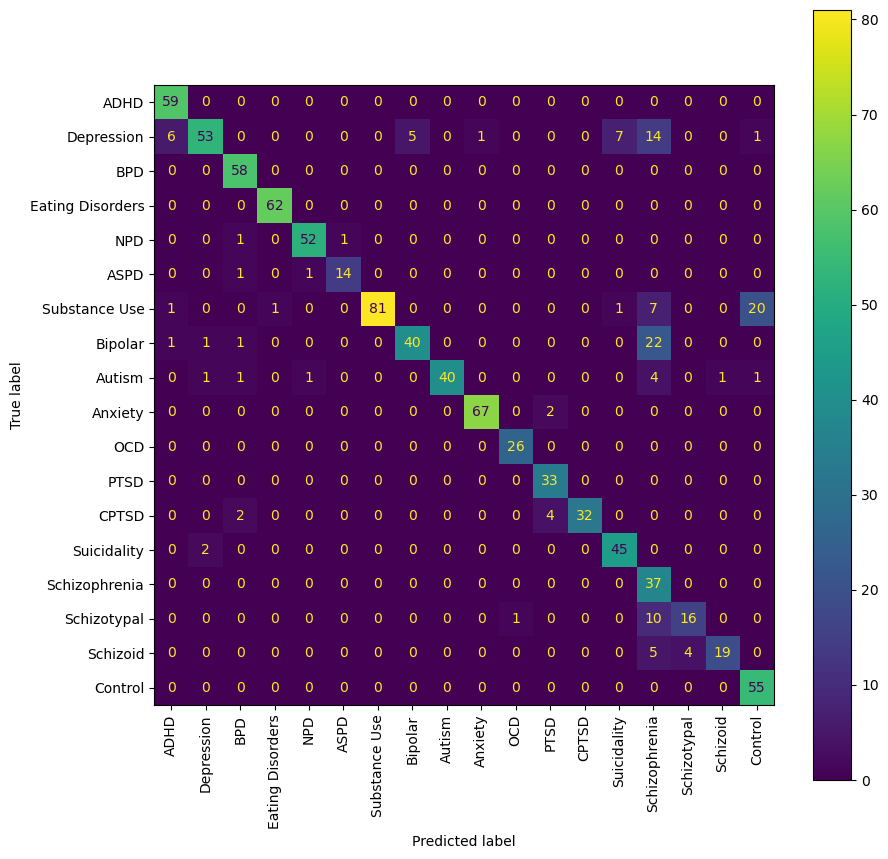

In [141]:
#Generate Figure 1 and Table 3:  Confusion Matrix and Classification Report of Community Embeddings Classified Using Model Trained With Individual User Post Embeddings


#Train Model
clf = LogisticRegression(random_state=0)
#clf_individualTrain = RandomForestClassifier(n_estimators=100)

clf = clf.fit(X_individual, y_individual)

preds = clf.predict(X_community)
probas = clf.predict_proba(X_community)

#Generate Table

report = classification_report(y_community, preds)

print(report)


#Generate Confusion Matrix

cm = confusion_matrix(y_community, preds)

f,ax = plt.subplots(1,1,figsize=(10,10))

cm_display = ConfusionMatrixDisplay(cm, display_labels = display_labels_crosstest).plot(ax = ax, xticks_rotation = 'vertical' )





              precision    recall  f1-score   support

           0       0.79      0.66      0.72        50
           1       0.35      0.54      0.42        50
           2       0.76      0.38      0.51        50
           3       0.92      0.46      0.61        50
           4       0.74      0.56      0.64        50
           5       1.00      0.08      0.15        50
           6       0.10      0.98      0.19        50
           7       0.57      0.32      0.41        50
           8       0.61      0.34      0.44        50
           9       0.50      0.46      0.48        50
          10       0.94      0.32      0.48        50
          11       0.79      0.30      0.43        50
          12       0.82      0.18      0.30        50
          13       0.83      0.20      0.32        50
          14       0.58      0.18      0.27       100
          15       0.83      0.10      0.18        50
          16       0.50      0.06      0.11        50
          17       0.72    

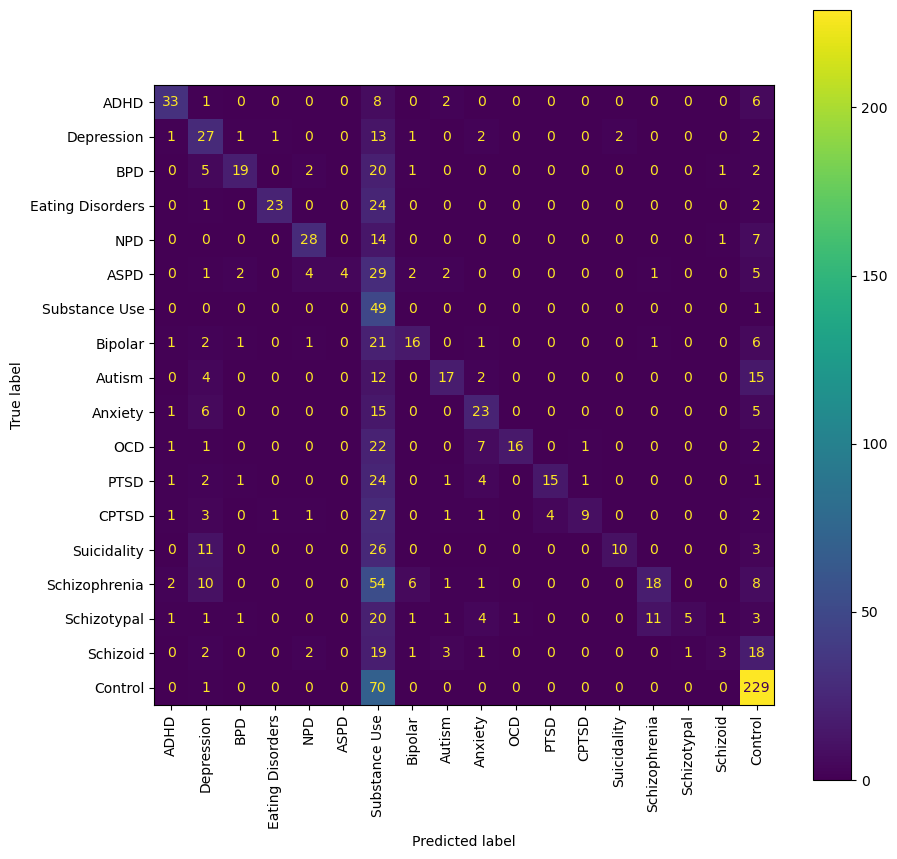

In [142]:
#Generate Figure 2 and Table 4:  Confusion Matrix and Classification Report of Individual Embeddings Classified Using Model Trained With Community Post Embeddings

#Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=0)

clf = clf.fit(X_community, y_community)

preds = clf.predict(X_individual)
probas = clf.predict_proba(X_individual)


#Generate Table


report = classification_report(y_individual, preds)

print(report)


#Generate Confusion Matrix

cm = confusion_matrix(y_individual, preds)

f,ax = plt.subplots(1,1,figsize=(10,10))

cm_display = ConfusionMatrixDisplay(cm, display_labels = display_labels_crosstest).plot(ax = ax, xticks_rotation = 'vertical' )

In [143]:
#Reload dataframe variables for zero-shot
df_community = pd.read_csv(r'C:\Users\alexa\Documents\Embedding_Dataframe.csv')
df_community_misinformation = pd.read_csv(r'C:\Users\alexa\df_community_misinformation.csv')
df_control_individual = pd.read_csv(r'C:\Users\alexa\df_control_individual.csv')
df_disorder_individual = pd.read_csv(r'C:\Users\alexa\df_disorder_individual.csv')

In [144]:
#Preparation of the final dataframes used for classification; Zero-Shot Classification Version
#If error occurs, try rerunning the cell that loads in the individual embeddings, then run this cell again.

y_individual = df_disorder_individual.Disorder_Index


df_disorder_individualTwo = df_disorder_individual
df_disorder_individualTwo.Disorder_Embedding = df_disorder_individualTwo.Disorder_Embedding.apply(eval).apply(np.array)
df_disorder_individualtemp = df_disorder_individualTwo.Disorder_Embedding.apply(pd.Series)
df_disorder_individualTwo = df_disorder_individualTwo.drop(columns = ['Disorder_Embedding'])
df_disorder_individualTwo = df_disorder_individualTwo.join(df_disorder_individualtemp)
df_disorder_individualTwo = df_disorder_individualTwo.to_numpy()



df_control_individualTwo = df_control_individual
df_control_individualTwo.Control_Embedding = df_control_individualTwo.Control_Embedding.apply(eval).apply(np.array)
df_control_individualtemp = df_control_individualTwo.Control_Embedding.apply(pd.Series)

y_individual_control = df_control_individualTwo.Control_Index


X_individual = df_disorder_individualtemp
X_individual = pd.concat([X_individual, df_control_individualtemp], axis = 0)

X_individual = X_individual.to_numpy()
y_individual = np.concatenate([y_individual, y_individual_control])
y_individual = y_individual.astype('int')



df_community_notzeroshot = df_community[df_community.Specific_Category != 18]
df_community_notzeroshot = df_community_notzeroshot[df_community_notzeroshot.Specific_Category != 19]


X_community = df_community_notzeroshot.iloc[:, 32:1568]
y_community = df_community_notzeroshot.Specific_Category
X_community = X_community.to_numpy()
y_community = y_community.to_numpy()
y_community = y_community.astype('int')


df_community_hate = df_community[df_community.Specific_Category == 18]
#df_community_misinformation = df_community[df_community.Specific_Category == 19]


X_community_hate = df_community_hate.iloc[:, 32:1568]
y_community_hate = df_community_hate.Specific_Category
X_community_hate = X_community_hate.to_numpy()
y_community_hate = y_community_hate.to_numpy()
y_community_hate = y_community_hate.astype('int')


X_community_misinformation = df_community_misinformation.iloc[:, 32:1568]
y_community_misinformation = df_community_misinformation.Specific_Category
X_community_misinformation = X_community_misinformation.to_numpy()
y_community_misinformation = y_community_misinformation.to_numpy()
y_community_misinformation = y_community_misinformation.astype('int')

display_labels_crosstest = ['ADHD', 'Depression', 'BPD', 'Eating Disorders', 'NPD', 'ASPD',  'Substance Use', 'Bipolar', 'Autism', 'Anxiety', 'OCD', 'PTSD', 'CPTSD', 'Suicidality', 'Schizophrenia', 'Schizotypal', 'Schizoid', 'Control'] 
display_labels_hate = ['ADHD', 'Depression', 'BPD', 'Eating Disorders', 'NPD', 'ASPD', 'Autism', 'Anxiety', 'CPTSD', 'Suicidality', 'Schizoid', 'Control', 'Hate']
display_labels_misinformation = ['NPD', 'Bipolar', 'Anxiety', 'PTSD', 'Schizophrenia', 'Control', 'Misinformation']

C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_cla

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       0.0
          17       0.00      0.00      0.00       0.0
          18       0.00      0.00      0.00     218.0

    accuracy                           0.00     218.0
   macro avg       0.00      0.00      0.00     218.0
weighted avg       0.00      0.00      0.00     218.0



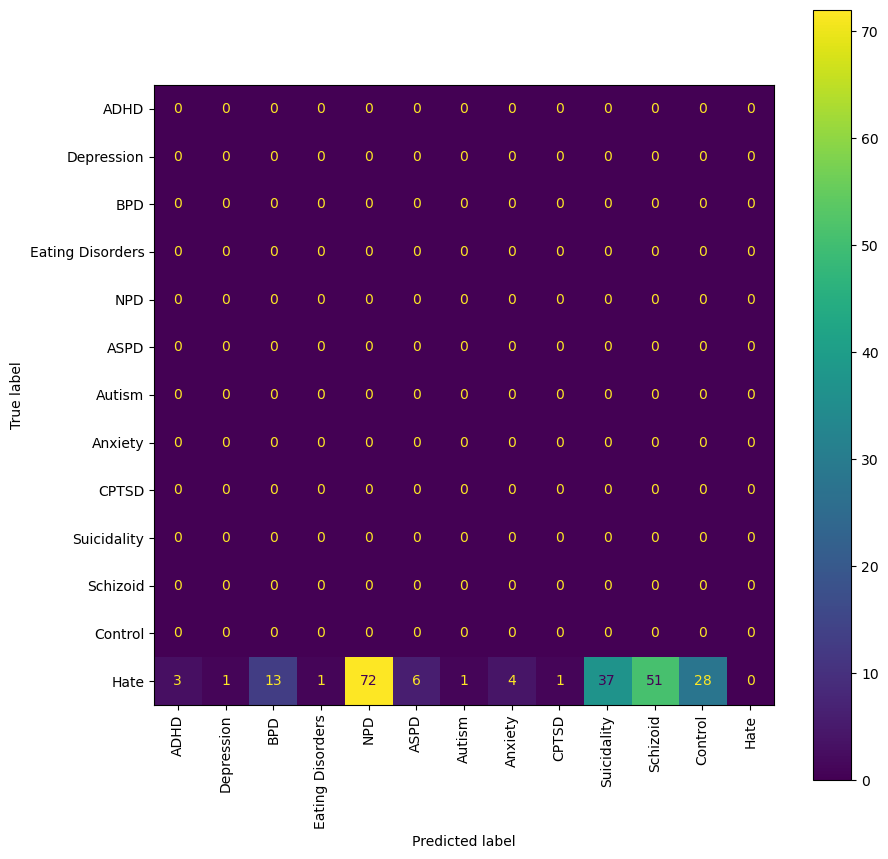

In [155]:
#Generate Figure 5:  Confusion Matrix of Zero-Shot Classification of Hate Speech Community Embeddings Using Individual Post Embeddings as Training Data

#Train Model


clf = LogisticRegression(random_state=0)

clf = clf.fit(X_individual, y_individual)

preds = clf.predict(X_community_hate)
probas = clf.predict_proba(X_community_hate)

preds_Hate = np.where(preds < 25, preds, (preds*0 + 17))

#Generate Table

report = classification_report(y_community_hate, preds_Hate)

print(report)


#Generate Confusion Matrix

cm = confusion_matrix(y_community_hate, preds_Hate)

f,ax = plt.subplots(1,1,figsize=(10,10))

cm_display = ConfusionMatrixDisplay(cm, display_labels = display_labels_hate).plot(ax = ax, xticks_rotation = 'vertical' )




C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\metrics\_cla

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00       0.0
         7.0       0.00      0.00      0.00       0.0
         9.0       0.00      0.00      0.00       0.0
        11.0       0.00      0.00      0.00       0.0
        14.0       0.00      0.00      0.00       0.0
        17.0       0.00      0.00      0.00       0.0
        19.0       0.00      0.00      0.00      65.0

    accuracy                           0.00      65.0
   macro avg       0.00      0.00      0.00      65.0
weighted avg       0.00      0.00      0.00      65.0



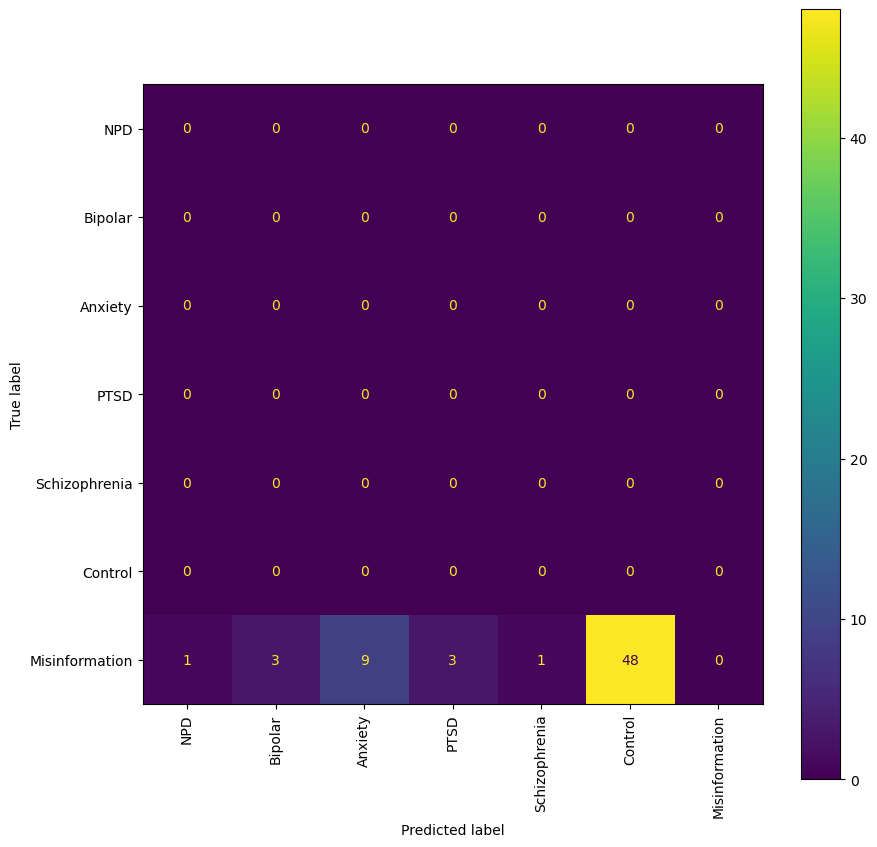

In [168]:
#Generate Figure 6:  Confusion Matrix of Zero-Shot Classification of Misinformation Community Embeddings Using Individual Post Embeddings as Training Data

#Train Model



X_community_misinformation =  np.genfromtxt('X_community_misinformation.csv', delimiter=',')
y_community_misinformation =  np.genfromtxt('y_community_misinformation.csv', delimiter=',')
X_individual =  np.genfromtxt('X_individual.csv', delimiter=',')
y_individual = np.genfromtxt('y_individual.csv', delimiter=',')



clf = LogisticRegression(random_state=0)

clf = clf.fit(X_individual, y_individual)

preds = clf.predict(X_community_misinformation)
probas = clf.predict_proba(X_community_misinformation)

preds_Misinformation = np.where(preds < 25, preds, (preds*0 + 17))


#Generate Table

report = classification_report(y_community_misinformation, preds_Misinformation)

print(report)



#Generate Confusion Matrix

cm = confusion_matrix(y_community_misinformation, preds_Misinformation)

f,ax = plt.subplots(1,1,figsize=(10,10))

cm_display = ConfusionMatrixDisplay(cm, display_labels = display_labels_misinformation).plot(ax = ax, xticks_rotation = 'vertical' )